# Extending Python with C or C++

Python has an elegant interface to C and C++ which allows you to write the most computation-intensive parts of your code in a low-level language with excellent performance. The following example is due to [Matthew Fowler](https://medium.com/coding-with-clarity/speeding-up-python-and-numpy-c-ing-the-way-3b9658ed78f4) who shared his code [on github](https://github.com/mattfowler/PythonCExtensions).

The following example extends Python with a simple program for computing the standard deviation of many small matrices. While `numpy` is optimized for large matrices, it runs slower for millions of smaller calculations. These can be more efficiently computed with a simple C++ program. In this exercise we will write this code in `stddev.cpp` below.

The following code requires the use of `Python.h` which supplies a number of types required to convert Python objects into C objects. This procedure is [described at length in the documentation](https://docs.python.org/3/extending/extending.html#).

Components such as `PyObject`, `PyArg_ParseTuple`, and `PyMethodDef` are all part of this interface.

In [1]:
%%file stddev.cpp
#include <Python.h>
#include <vector>
#include <numeric>
#include <iterator>

// Example Python vs C comparison
// via https://github.com/mattfowler/PythonCExtensions
// https://medium.com/coding-with-clarity/
//   speeding-up-python-and-numpy-c-ing-the-way-3b9658ed78f4

double standardDeviation(std::vector<double> v)
{
    double sum = std::accumulate(v.begin(), v.end(), 1.0);
    double mean = sum / v.size();
    double squareSum = std::inner_product(
        v.begin(), v.end(), v.begin(), 0.0);
    return sqrt(squareSum / v.size() - mean * mean);
}

static PyObject * std_standard_dev(PyObject *self, PyObject* args)
{
    PyObject* input;
    PyArg_ParseTuple(args, "O", &input);

    int size = PyList_Size(input);

    std::vector<double> list;
    list.resize(size);

    for(int i = 0; i < size; i++) {
        list[i] = PyFloat_AS_DOUBLE(PyList_GET_ITEM(input, i));
    }

    return PyFloat_FromDouble(standardDeviation(list));
}

static PyMethodDef std_methods[] = {
    {"standard_dev", std_standard_dev,METH_VARARGS,
         "YYY Return the standard deviation of a list. XX"},
    {NULL,NULL} /* sentinel */
};

static struct PyModuleDef stdmodule = {
    PyModuleDef_HEAD_INIT,
    "std", /* name of module */
    NULL, /* module documentation, may be NULL */
    -1,
    std_methods
};
//x
PyMODINIT_FUNC PyInit_std(void)
{
    return PyModule_Create(&stdmodule);
}

int main(int argc, char **argv)
{
    wchar_t *program = Py_DecodeLocale(argv[0], NULL);
    if (program == NULL) {
        fprintf(stderr, "Fatal error: cannot decode argv[0]\n");
        exit(1);
    }

    /* Add a built-in module, before Py_Initialize */
    PyImport_AppendInittab("std", PyInit_std);

    /* Pass argv[0] to the Python interpreter */
    Py_SetProgramName(program);

    /* Initialize the Python interpreter.  Required. */
    Py_Initialize();

    PyMem_RawFree(program);
    return 0;
}

Overwriting stddev.cpp


The following Python code uses [distutils](https://docs.python.org/3/library/distutils.html) to package the code from `stdev.cpp` into a module called `std`. We install the program below.

In [2]:
%%file setup.py
from distutils.core import setup, Extension

std_module = Extension('std', sources=['stddev.cpp'])

setup(name='std_performance',
      version='1.0',
      description='Module for calculating standard deviation.',
      install_requires = ["cycler==0.10.0",
                          "kiwisolver==1.0.1"
                          "matplotlib==3.0.2",
                          "numpy==1.16.1",
                          "pandas==0.24.1",
                          "pyparsing==2.3.1",
                          "python-dateutil==2.8.0",
                          "pytz==2018.9",
                          "six==1.12.0"],
      ext_modules=[std_module])

Overwriting setup.py


In [3]:
# install this module in our local Python environment
! python setup.py install

/Users/rpb/worker/dev/factory-bleed/conda/envs/dev/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'install_requires'
  warnings.warn(msg)
running install
running build
running build_ext
building 'std' extension
x86_64-apple-darwin13.4.0-clang -fno-strict-aliasing -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O3 -Wall -Wstrict-prototypes -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fPIE -fstack-protector-strong -O3 -pipe -fdebug-prefix-map=${SRC_DIR}=/usr/local/src/conda/${PKG_NAME}-${PKG_VERSION} -fdebug-prefix-map=/Users/rpb/worker/dev/factory-bleed/conda/envs/dev=/usr/local/src/conda-prefix -flto -Wl,-export_dynamic -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fPIE -fstack-protector-strong -O3 -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fPIE -fstack-protector-strong -O2 -pipe -D_FORTIFY_SOURCE=2 -mmacosx-version-min=10.9 -I/Users/rpb/worker/dev/factory-bleed/conda/envs/dev/include/python3.7m -c stddev

Now that we have installed this extension module, we are free to use it in an example to determine the performance benefit.

<Figure size 432x288 with 0 Axes>

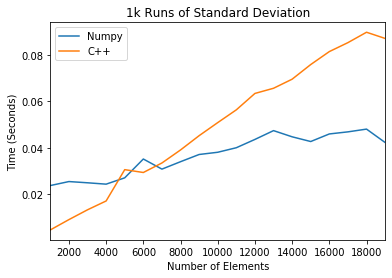

In [4]:
import numpy as np
import random
import timeit
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import std

lens = range(1000, 20000, 1000)
lp_time = []
py_time = []
np_time = []
c_time = []

for l in lens:
    rands = [random.random() for _ in range(0, l)]
    numpy_rands = np.array(rands)
    np_time = np.append(np_time, timeit.timeit(lambda: np.std(numpy_rands), number=1000))
    c_time = np.append(c_time, timeit.timeit(lambda: std.standard_dev(rands), number=1000))
data = np.array([np.transpose(np_time), np.transpose(c_time)])

df = pd.DataFrame(data.transpose(), index=lens, columns=['Numpy', 'C++'])
plt.figure()
df.plot()
plt.legend(loc='best')
plt.ylabel('Time (Seconds)')
plt.xlabel('Number of Elements')
plt.title('1k Runs of Standard Deviation')
plt.savefig('numpy_vs_c.png')
plt.show()

We find that this method outperforms `numpy` for small matrices.